# CIFAR-10 data loader functions

In [1]:
import os
import subprocess
from urllib.request import urlretrieve
import tarfile
import numpy as np
import pickle
import sys
from PIL import Image

In [2]:
curr_dir = os.getcwd()

In [3]:
######################################################################
# Setup working directory
######################################################################
os.chdir(curr_dir)
data_dir = os.path.join(curr_dir, 'data/')

if not os.path.exists(data_dir):
    subprocess.run(['mkdir', data_dir])

os.chdir(data_dir)

In [4]:
######################################################################
# Helper functions for loading data
######################################################################
# adapted from 
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py
def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto'):

    if untar:
        untar_fpath = os.path.join(data_dir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print('File path: %s' % fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(data_dir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, data_dir, archive_format)

    return fpath

def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

# Load data

In [5]:
# Download cluster centers for k-means over colours
colours_fpath = get_file(fname='colours', 
                         origin='http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz', 
                         untar=True)
# Download CIFAR dataset
m = load_cifar10()

File path: /Users/abew/Documents/ML-practice/colorize-images/data/colours.tar.gz
File path: /Users/abew/Documents/ML-practice/colorize-images/data/cifar-10-batches-py.tar.gz


# Colourization as Classification

Select a subset of 24 colours and frame colourization as a pixel-wise classification problem, where we label each pixel with one of 24 colours. The 24 colours are selected using [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) over colours, and selecting cluster centers. 

The cluster centers are provided in http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz, and downloaded by the helper functions above. For simplicity, though it is not ideal, measure distance in RGB space.

In [6]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
from __future__ import print_function
import argparse
import math
import time

import numpy as np
import numpy.random as npr
import scipy.misc
import matplotlib
import matplotlib.pyplot as plt 

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers


#from load_data import load_cifar10

CIFAR_10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

lookup_dict = {label:i for i, label in enumerate(CIFAR_10_LABELS)}

CATEGORY = lookup_dict['horse']

In [7]:
def get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values.
    Args:
      xs: float numpy array of RGB images in [B, H, W, C] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, H, W, 1]
    """

    def helper(xs, colours):
        """
        Get colour categories given RGB values. This is done by choosing
        the colour in `colours` that is the closest (in RGB space) to
        each point in the image `xs`. This function is a little memory
        intensive, and so the size of `xs` should not be too large.

        Args:
          xs: float numpy array of RGB images in [B, H, W, C] format
          colours: numpy array of colour categories and their RGB values
        Returns:
          result: int numpy array of shape [B, H, W, 1]
        """
        num_colours = np.shape(colours)[0]
        xs = np.expand_dims(xs, 0)
        cs = np.reshape(colours, [num_colours,1,1,1,3])
        dists = np.linalg.norm(xs-cs, axis=-1) # -1 = colour axis
        cat = np.argmin(dists, axis=0)
        cat = np.expand_dims(cat, axis=-1)
        return cat
    
    # limit the batch_size to max of 100
    if np.shape(xs)[0] < 100:
        return helper(xs)
    
    batch_size = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_size):
        next_val = helper(xs[i:i+batch_size,:,:,:], colours)
        nexts.append(next_val)
    result = np.concatenate(nexts, axis=0)
    return result

def get_cat_rgb(cats, colours):
    """
    Get RGB colours given the colour categories

    Args:
      cats: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[cats]

def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the specified category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == CATEGORY)[0], :, :, :]
    npr.shuffle(xs)
    
    xs = np.transpose(xs, [0,2,3,1])
    
    grey = np.mean(xs, axis=-1, keepdims=True)

    if downsize_input:
        downsize_module = keras.Sequential(
            layers = [layers.AveragePooling2D(2),
                      layers.AveragePooling2D(2),
                      layers.UpSampling2D(2),
                      layers.UpSampling2D(2)
                     ]
        )
        xs_downsized = downsize_module(
            tf.convert_to_tensor(xs))
        xs_downsized = xs_downsized.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)

# Build model

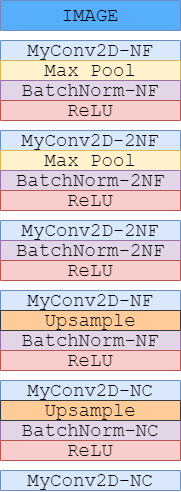

In [58]:
from models.simple_cnn import colorizer_model
from models.cnn_skip_conn import colorizer_model as colorizer_model_skip

In [59]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
def train(args, cnn=None):
    # Numpy random seed
    npr.seed(args.seed)

    # select save directory
    save_dir = os.path.join(curr_dir,"outputs",args.experiment_name)

    # LOAD THE COLOURS CATEGORIES 'ASCII', 'latin1', or 'bytes'
    colours = np.load(args.colours, allow_pickle=True, encoding='bytes')[0]
    num_colours = np.shape(colours)[0]
    
    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3

    # LOAD THE MODEL
    if args.model == 'CNN':
        model = colorizer_model
    elif args.model == 'CNN_SKIP':
        model = colorizer_model_skip
    else:
        raise ValueError('Please select from CNN and CNN_SKIP for model')
        return
    cnn = model(
        args.img_size+[num_in_channels],
        args.kernel, 
        args.num_filters, 
        num_colours,
        optimizer = args.optimizer,
        loss = args.loss,
        lr = args.learn_rate
    )
    
#     # show the model summary
#     cnn.summary()
    
    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input = args.downsize_input)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir) 
    
    print("Beginning training ...")    
    board_params = keras.callbacks.TensorBoard(log_dir=os.path.join(curr_dir,'logs'),
                                                histogram_freq=5, 
                                                write_images=True,
                                                )
    model_saver = keras.callbacks.ModelCheckpoint(os.path.join(save_dir, 'checkpoint'),
                                               monitor='val_loss',
                                               mode='min',
                                               save_best_only=True,
                                                 )
    callbacks = [model_saver] #, board_params]
    
    history = cnn.fit(x = train_grey,
                        y = train_rgb_cat,
                        batch_size = args.batch_size,
                        epochs = args.epochs,
                        callbacks = callbacks,
                        validation_split = 0.2,
                        shuffle = True,
                        workers = 1,
                        use_multiprocessing = False,
                        verbose=1
                       )
    train_losses = cnn.evaluate(x = train_grey, y = train_rgb_cat)
    test_losses = cnn.evaluate(x = test_grey, y = test_rgb_cat)

    return history, train_losses, test_losses, cnn


In [60]:
args = AttrDict()
args_dict = {
              'checkpoint':"", 
              'colours': data_dir + '/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'img_size':[32,32],
              'num_filters':32,
              'optimizer':'adam',
              'loss': custom_loss,
              'learn_rate':0.3, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'experiment_name': 'colourization_cnn',
              'downsize_input':False,
}
args.update(args_dict)
hist, train_losses, test_losses, model= train(args)

ValueError: Please select from CNN and CNN_SKIP for model

In [16]:
print(train_losses)
print(test_losses)

[2.1526072025299072, 2.1521780490875244]
[2.15226149559021, 2.15339732170105]


In [17]:
final_model = colorizer_model(
        args.img_size+[1],
        args.kernel, 
        args.num_filters, 
        24,
        optimizer = args.optimizer,
        loss = args.loss,
        lr = args.learn_rate
    )

In [18]:
final_model.load_weights(os.path.join(curr_dir,"outputs",args.experiment_name, 'checkpoint'))

2022-01-04 19:11:09.379848: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /Users/abew/Documents/ML-practice/colorize-images/outputs/colourization_cnn/checkpoint: Failed precondition: /Users/abew/Documents/ML-practice/colorize-images/outputs/colourization_cnn/checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [19]:
print("Loading data...")
(x_train, y_train), (x_test, y_test) = load_cifar10()

colours = np.load(args.colours, allow_pickle=True, encoding='bytes')[0]

print("Transforming data...")
train_rgb, train_grey = process(x_train, y_train, downsize_input = args.downsize_input)
train_rgb_cat = get_rgb_cat(train_rgb, colours)
test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
test_rgb_cat = get_rgb_cat(test_rgb, colours)

print("completed")

Loading data...
File path: /Users/abew/Documents/ML-practice/colorize-images/data/cifar-10-batches-py.tar.gz
Transforming data...
completed


In [20]:
train_losses_2 = final_model.evaluate(x = train_grey, y = train_rgb_cat)
test_losses_2 = final_model.evaluate(x = test_grey, y = test_rgb_cat)

32/32 [==============================] - 2s 63ms/step - loss: 2.0447 - custom_loss: 2.0462


In [21]:
print(train_losses_2)
print(test_losses_2)

[2.052584648132324, 2.0521390438079834]
[2.0447402000427246, 2.046159267425537]


In [22]:
sample_test = test_grey[:10]

pred = final_model.predict(sample_test).astype(int)

pred = np.expand_dims(np.argmax(pred, axis=-1),axis=-1)
print(pred.shape)

(10, 32, 32, 1)


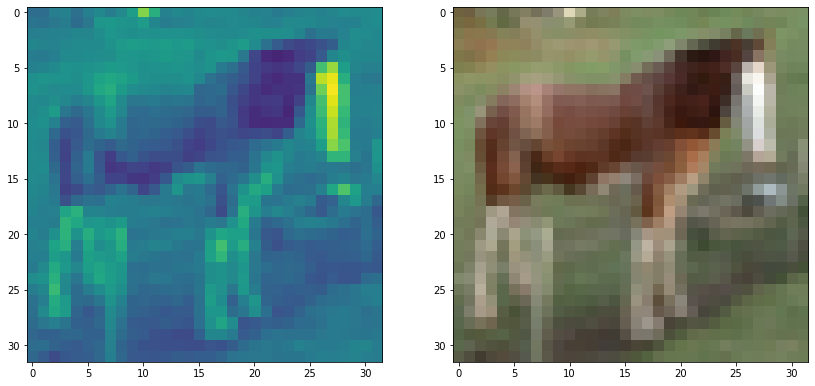

In [23]:
fig,ax = plt.subplots(ncols=2, figsize=(14,8))

# ax[0].imshow(pred[0].mean(axis=-1))
ax[0].imshow(sample_test[2], vmin=0, vmax=1)
ax[1].imshow(test_rgb[2], vmin=0, vmax=256)

plt.show()

In [24]:
def plot(grey, gtlabel, output, colours):
    """
    Generate png plots of input, ground truth, and outputs

    Args:
      sample: the greyscale input to the colourization CNN
      gtlabel: the grouth truth categories for each pixel
      output: the predicted categories for each pixel
      colours: numpy array of colour categories and their RGB values
    """
    gtlabel = np.transpose(gtlabel[:10,:,:,:], [0,3,1,2])
    output = np.transpose(output[:10,:,:,:], [0,3,1,2])
    
    
    gtcolor = get_cat_rgb(gtlabel[:10,0,:,:], colours)
    predcolor = get_cat_rgb(output[:10,0,:,:], colours)

    img_stack = [
      np.hstack(np.tile(grey, [1,1,1,3])),
      np.hstack(gtcolor),
      np.hstack(predcolor)]
    
    img = np.vstack(img_stack)
    plt.figure(figsize=(14,8))
    plt.grid('off')
    plt.imshow(img, vmin=0., vmax=1.)
    plt.show()

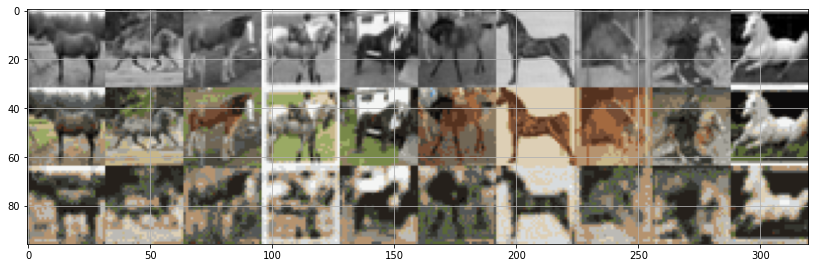

In [25]:
plot(sample_test, test_rgb_cat, pred.astype('int'), colours)